In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/Colab Notebooks/dataset_32x32.zip' -d '/content/drive/MyDrive/Colab Notebooks/'

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2 as cv
from matplotlib import pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score

from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Input, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

In [ ]:
def read_data():
  # Read
  df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/100px_NoFaceDetected.pkl')

  # Remove 'fear' class
  df = df[df['class'] != 1].copy()
  df['class'] = df['class'].apply(lambda x: x-1 if x > 1 else x)
  return df

Benchmark Model Architecture

In [ ]:
def build_benchmark_model():
    net = Sequential(name='Benchmark_Model')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(48, 48, 1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            5,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.001),
        metrics=['accuracy']
    )
    
    return net

In [ ]:
benchmark = build_benchmark_model()
benchmark.summary()

Model: "Benchmark_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        1664      
                                                                 
 batchnorm_1 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 conv2d_2 (Conv2D)           (None, 48, 48, 64)        102464    
                                                                 
 batchnorm_2 (BatchNormaliza  (None, 48, 48, 64)       256       
 tion)                                                           
                                                                 
 maxpool2d_1 (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 24, 24, 64)    

Proposed Model Architecture

In [ ]:
def build_model():

    num_classes = 5
    model = Sequential(name='Proposed_Model')

    model.add(
        Conv2D(
            filters=32,
            kernel_size=(5,5),
            input_shape=(100, 100, 1),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            filters=32,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            filters=64,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal'
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    model.add(BatchNormalization())
    model.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.4))

    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    model.add(BatchNormalization())

    model.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
        )
    )
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Dropout(0.6))

    model.add(Flatten())
        
    model.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
        )
    )
    model.add(BatchNormalization())
    
    model.add(Dropout(0.25))
    
    model.add(
        Dense(
            num_classes,
            activation='softmax',
        )
    )
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=Adam(learning_rate=0.0005),
        metrics=['accuracy']
    )
    
    return model

In [ ]:
proposed_model = build_model()
proposed_model.summary()

Model: "Proposed_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_213 (Conv2D)         (None, 100, 100, 32)      832       
                                                                 
 batch_normalization_1 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_214 (Conv2D)         (None, 100, 100, 32)      25632     
                                                                 
 batch_normalization_2 (Batc  (None, 100, 100, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_101 (MaxPooli  (None, 50, 50, 32)       0         
 ng2D)                                                           
                                                    

Training Model Function

In [ ]:
# CSV Logger
csv_logger = CSVLogger('/content/drive/MyDrive/Colab Notebooks/benchmark_history.csv', append=True, separator=',')

# Early Stopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=7,
    verbose=1,
    restore_best_weights=True,
)

# Train Model Function
def train_model(model, X_train, y_train, X_test, y_test):
    # Image Augmentation
    train_gen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        width_shift_range=0.2,
        height_shift_range=0.1,
        zoom_range=0.1,
        shear_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval=0)
    train_gen.fit(X_train)

    val_gen = ImageDataGenerator(rescale=1./255)
    val_gen.fit(X_test)
    history = model.fit(train_gen.flow(X_train, y_train),   
                        epochs=100,
                        batch_size=64, 
                        validation_data=val_gen.flow(X_test, y_test),
                        callbacks=[early_stopping, csv_logger],
                        shuffle=True)
    return history

In [ ]:
def select_fold_train(splits, fold, img_size):
  for n, (train_index,test_index) in enumerate(splits):
    if n+1 == fold:
      print(f'\n\nTraining on Fold {fold}...\n\n')

      # Split DataFrame
      train_df = df.iloc[train_index]
      test_df = df.iloc[test_index]

      # Train Test
      X_train = np.array(train_df['image'].tolist())
      y_train = np.array(train_df['class'].tolist())
      X_test = np.array(test_df['image'].tolist())
      y_test = np.array(test_df['class'].tolist())

      X_train = np.array([x for x in X_train]).reshape(-1, img_size, img_size, 1)
      X_test = np.array([x for x in X_test]).reshape(-1, img_size, img_size, 1)
      y_train = to_categorical(y_train)
      y_test = to_categorical(y_test)

      # CNN Model
      model = None
      model = build_benchmark_model()

      # Train Model
      history = train_model(model, X_train, y_train, X_test, y_test)

      # Model Predictions
      X_test = X_test/255.0
      predictions = model.predict(X_test)

      pred = []
      true = []

      for prediction in predictions:
          pred.append(prediction.argmax())

      for y_val in y_test:
          true.append(y_val.argmax()) 

      # Fold Accuracy
      score = accuracy_score(true, pred)
      print(f"\n\nFold {fold} Accuracy: {score}\n\n")
      
      return score, true, pred

Benchmark Model Training

In [ ]:
IMG_SIZE = 48

df = read_data()
df['image'] = df['image'].apply(lambda x: cv.resize(x, (48, 48)))

kf = StratifiedKFold(5, shuffle=True, random_state=42) 
splits = kf.split(df, df['class'])

for fold in range(5):
    score, true, pred = select_fold_train(splits, fold+1, IMG_SIZE)

    true = pd.DataFrame(true)
    pred = pd.DataFrame(pred)

    Kfold_df = pd.concat([true, pred], axis=1)
    Kfold_df.columns = ['True', 'Pred']
    Kfold_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/KFOLD_{fold}_Benchmark_Result.csv')

Proposed Model Training

In [ ]:
IMG_SIZE = 100

df = read_data()

kf = StratifiedKFold(5, shuffle=True, random_state=42) 
splits = kf.split(df, df['class'])

for fold in range(5)
    score, true, pred = select_fold_train(splits, fold+1, IMG_SIZE)

    true = pd.DataFrame(true)
    pred = pd.DataFrame(pred)

    Kfold_df = pd.concat([true, pred], axis=1)
    Kfold_df.columns = ['True', 'Pred']
    Kfold_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/KFOLD_{fold+1}_Result.csv')

In [ ]:
 def plot_kfold_history(data, fold):
  fig, axs = plt.subplots(2, figsize=(6, 7))
  axs[0].plot(data["accuracy"], label="train")
  axs[0].plot(data["val_accuracy"], label="test")
  axs[0].set_ylabel("Accuracy")
  axs[0].set_ylim([0.2, 0.8])
  axs[0].legend(loc="lower right")
  axs[0].set_title(f"Accuracy")

  axs[1].plot(data["loss"], label="train")
  axs[1].plot(data["val_loss"], label="test")
  axs[1].set_ylabel("Error")
  axs[1].set_xlabel("Epoch")
  axs[1].set_ylim([0.5, 2])
  axs[1].legend(loc="upper right")
  axs[1].set_title(f"Error")

  plt.show()

In [ ]:
train_benchmark_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/benchmark_history.csv')

fold_split = list(train_benchmark_log.loc[train_benchmark_log.epoch==0].index)
fold_split.append(133)
fold_split

for n, index in enumerate(fold_split):
  if n+1 == len(fold_split):
    break
  if n == 3:
    fold_indexes = [x for x in range(fold_split[n], fold_split[n+1])]
    data = train_benchmark_log.iloc[fold_indexes, :]
    data.reset_index(drop=True, inplace=True)
    print(data)

    epoch  accuracy      loss  val_accuracy  val_loss
0       0  0.296547  1.720236      0.396981  1.389802
1       1  0.427069  1.370048      0.503914  1.206120
2       2  0.497938  1.231423      0.489516  1.404169
3       3  0.548469  1.139882      0.518032  1.237431
4       4  0.578627  1.074771      0.567095  1.135001
5       5  0.607597  1.027789      0.589181  1.111093
6       6  0.618500  1.000756      0.607912  1.118268
7       7  0.629193  0.978197      0.626642  0.992056
8       8  0.640830  0.951424      0.595611  1.090567
9       9  0.646491  0.937473      0.629997  1.014368
10     10  0.658233  0.913521      0.644954  0.967152
11     11  0.664139  0.895497      0.642717  0.929674
12     12  0.669835  0.890628      0.648868  0.940502
13     13  0.675461  0.875560      0.616438  1.078702
14     14  0.675846  0.864872      0.668996  0.900282
15     15  0.681891  0.852065      0.656416  0.964662
16     16  0.684407  0.846962      0.680319  0.887017
17     17  0.690907  0.83507

In [ ]:
train_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/model_history.csv')

fold_split = list(train_log.loc[train_log.epoch==0].index)
fold_split.append(133)
fold_split

for n, index in enumerate(fold_split):
  if n+1 == len(fold_split):
    break
  if n == 2:
    fold_indexes = [x for x in range(fold_split[n], fold_split[n+1])]
    data = train_log.iloc[fold_indexes, :]
    data.reset_index(drop=True, inplace=True)
    print(data)

    epoch  accuracy      loss  val_accuracy  val_loss
0       0  0.295883  1.689971      0.436539  1.365614
1       1  0.418961  1.388334      0.521666  1.204431
2       2  0.515166  1.196656      0.560386  1.133896
3       3  0.562448  1.099483      0.571289  1.154443
4       4  0.595925  1.035184      0.636008  0.951674
5       5  0.621331  0.980368      0.661448  0.877144
6       6  0.638454  0.943374      0.685630  0.811990
7       7  0.653446  0.907189      0.698910  0.795612
8       8  0.666341  0.882816      0.692759  0.805068
9       9  0.674343  0.859949      0.702125  0.799888
10     10  0.685875  0.837389      0.720716  0.750938
11     11  0.693633  0.818816      0.712608  0.761296
12     12  0.704256  0.797060      0.723092  0.751344
13     13  0.706213  0.790190      0.736791  0.711165
14     14  0.713272  0.775952      0.722253  0.777931
15     15  0.715159  0.767853      0.739446  0.717605
16     16  0.719108  0.758919      0.732877  0.725044
17     17  0.723966  0.74224

Training Graphs of Benchmark Model

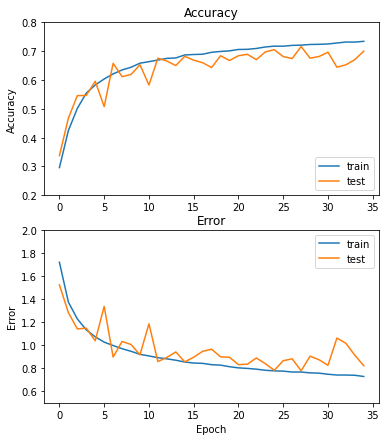

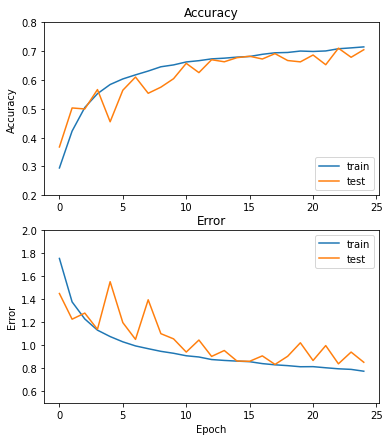

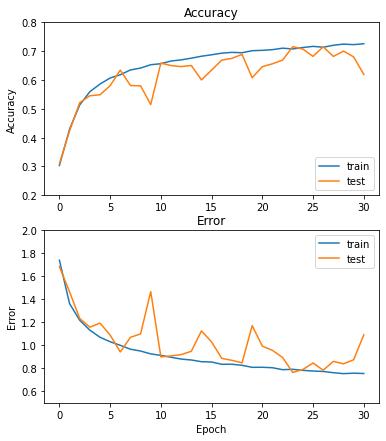

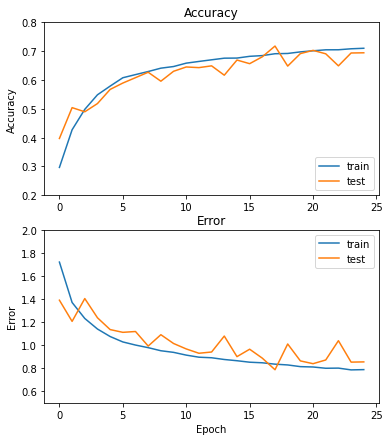

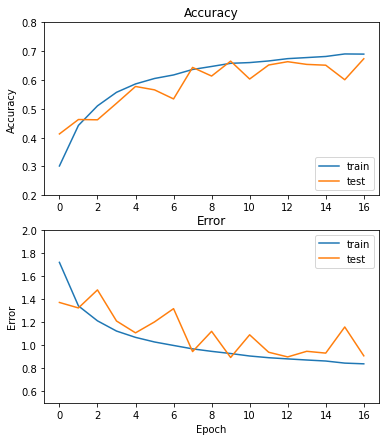

In [ ]:
train_benchmark_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/benchmark_history.csv')

fold_split = list(train_benchmark_log.loc[train_benchmark_log.epoch==0].index)
fold_split.append(133)
fold_split

for n, index in enumerate(fold_split):
  if n+1 == len(fold_split):
    break

  fold_indexes = [x for x in range(fold_split[n], fold_split[n+1])]
  data = train_benchmark_log.iloc[fold_indexes, :]
  data.reset_index(drop=True, inplace=True)
  plot_kfold_history(data, n+1)

Training Graphs of Proposed Model

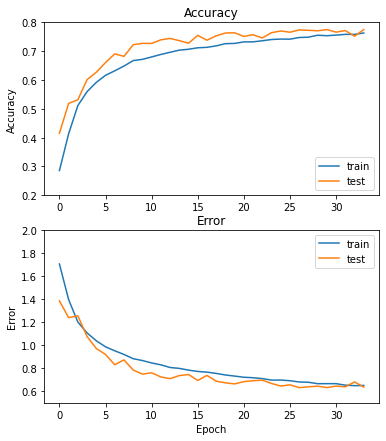

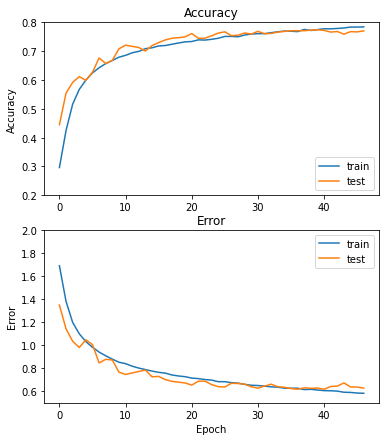

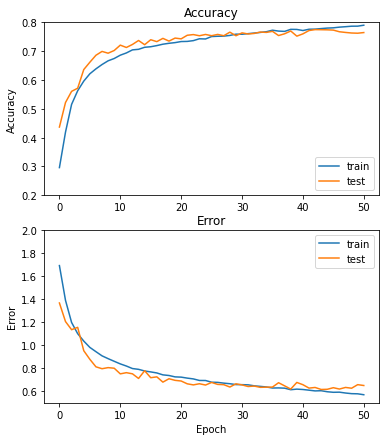

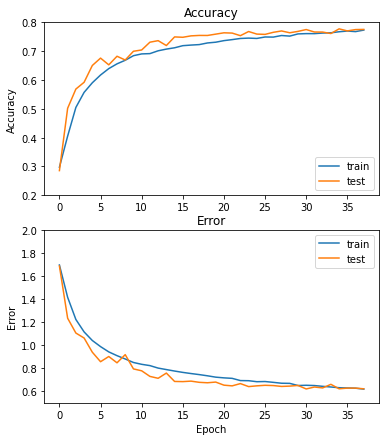

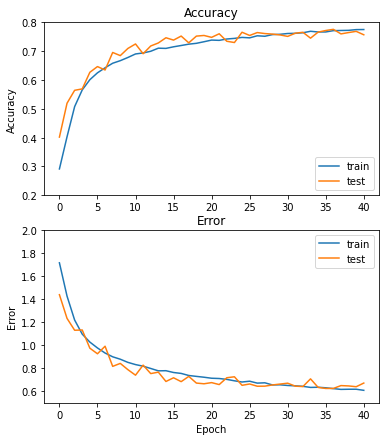

In [ ]:
train_log = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/model_history.csv')

fold_split = list(train_log.loc[train_log.epoch==0].index)
fold_split.append(211)

for n, index in enumerate(fold_split):
  if n+1 == len(fold_split):
    break

  fold_indexes = [x for x in range(fold_split[n], fold_split[n+1])]
  data = train_log.iloc[fold_indexes, :]
  data.reset_index(drop=True, inplace=True)
  plot_kfold_history(data, n+1)

K Fold Accuracy of Benchmark Model

In [ ]:
for fold_num in range(5):
  data = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/KFOLD_{fold_num+1}_Benchmark_Result.csv')
  print(f'Fold {fold_num+1}')
  print(accuracy_score(data['True'], data['Pred']))
  print('\n')

Fold 1
0.7159630975677942


Fold 2
0.6912216941571149


Fold 3
0.715403969807101


Fold 4
0.7175006989097009


Fold 5
0.6652222532848756




K Fold Accuracy of Proposed Model

In [ ]:
for fold_num in range(5):
  data = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/KFOLD_{fold_num+1}_Result.csv')
  print(f'Fold {fold_num+1}')
  print(accuracy_score(data['True'], data['Pred']))
  print('\n')

Fold 1
0.7718758736371261


Fold 2
0.7742521666200727


Fold 3
0.774811294380766


Fold 4
0.7735532569192061


Fold 5
0.7714565278166061




Paired T-Test Accuracy

In [ ]:
import statistics

benchmark_accuracy = [0.71596, 0.69122, 0.71540, 0.71750, 0.66522]
proposed_accuracy = [0.77188, 0.77425, 0.77481, 0.77355, 0.77146]

print(f'Benchmark Average Accuracy: {statistics.mean(benchmark_accuracy)}')
print(f'Proposed Average Accuracy: {statistics.mean(proposed_accuracy)}')

Benchmark Average Accuracy: 0.70106
Proposed Average Accuracy: 0.77319


In [ ]:
from scipy.stats import ttest_rel

ttest_rel(benchmark_accuracy, proposed_accuracy)

Ttest_relResult(statistic=-7.27615645968863, pvalue=0.0018955825193018722)

Confusion Matrix of Benchmark Model

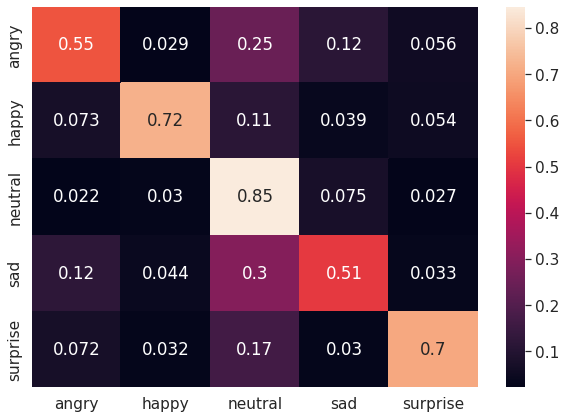

In [ ]:
emotions = os.listdir('/content/drive/MyDrive/Colab Notebooks/dataset')
emotions.sort()

benchmark_predictions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KFOLD_5_Benchmark_Result.csv')
true = benchmark_predictions['True']
pred = benchmark_predictions['Pred']

mat = confusion_matrix(true, pred)
df_cm = pd.DataFrame(mat, index = emotions,
                  columns = emotions)
df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)

plt.figure(figsize = (10,7))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True)
plt.show()

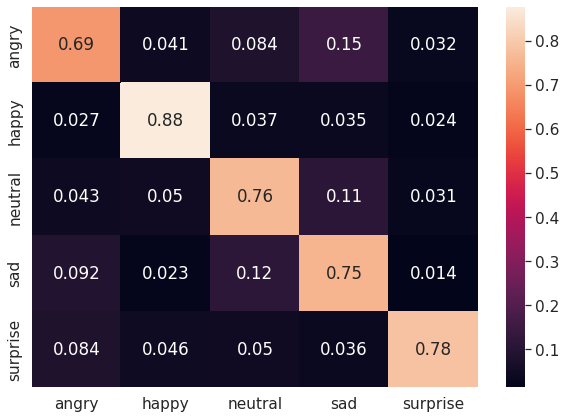

In [ ]:
emotions = os.listdir('/content/drive/MyDrive/Colab Notebooks/dataset')
emotions.sort()

model_predictions = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/KFOLD_3_Result.csv')
true = model_predictions['True']
pred = model_predictions['Pred']

mat = confusion_matrix(true, pred)
df_cm = pd.DataFrame(mat, index = emotions,
                  columns = emotions)
df_cm = df_cm.div(df_cm.sum(axis=1), axis=0)

plt.figure(figsize = (10,7))

sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True)
plt.show()